# **Preprocesing**

### **Exploring Dataset**

Dalam tahapan ini kita akan melakukan importing beberapa asset yang dibutuhkan seperti library yang dibutuhkan, dataset yang dibutuhkan

In [2]:
# import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud.wordcloud import WordCloud


In [3]:
# untuk mengimport dataset
df = pd.read_csv("chatgpt_reviews.csv")

# untuk melihat isi data
df.head()

,date,title,review,rating
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4


setelah itu kita akan melakukan perhitungan ada berapa banyak review untuk masing masing rating 

In [4]:
# untuk menghitung nilai unik
df["rating"].value_counts()

rating
5    1134
1     495
4     304
3     220
2     139
Name: count, dtype: int64

berdasarkan dari data di atas, kita dapat menyimpulkan untuk komentar positif itu pada rating 5 dan untuk komentar negatif itu pada rating 1. Mengapa hanya rating 1 dan 5 ? karena kalau komentar 2 - 4 itu masih termasuk pendapat. 

Dan juga kita dapat melihat banyaknya data yang rating 5 dengan data dengan rating 1 sangatlah berbeda jauh perbedaannya, maka kita perlu menyeimbangkan data ini untuk menghindari potensi overfitting

### **Feature Selection**

dalam tahapan ini kita akan memilih fitur yang berguna saja. Jadi kita dapat membuang fitur yang tidak digunakan. Dalam kasus ini kita hanya membutuhkan text komentar sebagai x nya dan label (rating) sebagai y nya

In [5]:
# menghapus fitur
df.drop(columns=["date", "title"], inplace=True)

df

,review,rating
0,Up to this point I’ve mostly been using ChatGP...,4
1,I’ve been a user since it’s initial roll out a...,4
2,This app would almost be perfect if it wasn’t ...,4
3,"I recently downloaded the app and overall, it'...",4
4,I appreciate the devs implementing Siri suppor...,4
...,...,...
2287,This has to be a beginning to something crazy ...,5
2288,I’ve been using chat and have been a proud pre...,5
2289,The ChatGPT iOS app is an outstanding product....,5
2290,Sam Altman’s blatant attempt at regulatory cap...,2


### **Duplicated Data**

pada tahapan ini kita akan menghapuskan untuk data yang tak diperlukan lagi. Tujuannya adalah agar tidak terjadi nya pembelajaran yang sama pada model kita. Jika hal ini dipaksakan, hal ini akan berpotensi terjadinya overfitting

In [6]:
# menampilkan data yang terduplikasi
df[df.duplicated()]

,review,rating
1351,Thanks,5
1508,Please,5
1783,Love it,5
1800,First,5
1801,First,5
1802,First,5
1827,Why?,1
1853,Very good,5
1866,Pretty good,5
1869,Great,5


dari tampilan di atas sangat jelas kalau ada data yang terduplikasi. Maka kita perlu membiarkan satu data saja pada data yang terduplikasi tersebut

In [7]:
# menghilangkan data terduplikasi
df.drop_duplicates(inplace=True)

# melihat apakah ada data yang terduplikasi
df[df.duplicated()]

,review,rating


### **Missing Value**

Pada tahapan ini kita akan mencari apakah ada data yang kosong atau tidak. Hal ini bertujuan untuk menghindari terjadinya error pada proses modeling dan juga menghindari kesalah pahaman pada model (misal Nan akan dianggap dokumen yang berisi kata Nan)

In [8]:
# melihat missing jenis Nan
df.isna().sum()

review    0
rating    0
dtype: int64

In [9]:
# melihat missing jenis null
df.isnull().sum()

review    0
rating    0
dtype: int64

In [10]:
# karakter unik
df.rating.unique()

array([4, 1, 3, 5, 2], dtype=int64)

Tidak ditemukan data yang hilang, maka kita bisa mengabaikannya saja

setelah dilakukan cleaning, maka kita perlu menyeimbangkan banyaknya data agar tidak menjadi overfitting

In [11]:
# mengambil data yang diperlukan
df = pd.concat([df[df["rating"] == 5].iloc[:500], df[df["rating"] == 1]])\
    .sample(frac=1, random_state=123)

# menampilkan data
df.head(10)

,review,rating
282,Can’t thank the OpenAI Team enough for the bea...,5
709,Surprised apple let this through its approval ...,1
2272,Beware!!! This app requires personal info to u...,1
2251,It's not sending me the code to verify my number,1
293,The UI is clean and the haptic feedback is app...,5
1378,Thinks my cell number is a landline. No way ar...,1
1404,I updated chatgpt but it wont answer to my que...,1
701,"Hello, do you guys have a timeline of when wou...",5
555,This Mobile App works very well and is effecti...,5
456,This app is an absolute game changer and I abs...,5


### **Train Test Split**

Pada tahapan ini kita akan memisahkan data yang hanya digunakan untuk test (data test) dan data yang digunakan untuk training (data train). Tujuan dari splitting ini adalah agar kita mengetahui performa dari model kita

In [12]:
# mengembalikan data yang sudah di split train dengan test
def Train_Test_Split(x, y, test_size=0.2, random_seed=None):
    # banyaknya data
    n = len(x)

    # jika ada random seed
    if random_seed:
        np.random.seed(random_seed)

    # menentukan banyaknya data test
    test_size = int(test_size * n)

    # matrix random
    indices = np.random.permutation(n)

    # menentukan train dan test 
    train_indices, test_indices = indices[test_size:], indices[:test_size]
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# menentukan x dan y nya
x = df["review"]
y = df["rating"]

# mengimplementasikan pada dataset
X_train, X_test, y_train, y_test = Train_Test_Split(x, y, test_size=0.2, random_seed=123)

X_train

1525            This app is asking for your phone number.
2002          有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？
823     I pay for plus and can access browsing and plu...
37      I don’t typically write review but this offici...
1832    It agrees with letting children be forced into...
                              ...                        
171     Please make the ipad version fit the screen. C...
655     Works as it should but drains battery fast and...
1656                          Fails right out of the box.
1498                  Heating problems when ask something
1355    Simple as that. It works about 1 out of 7 time...
Name: review, Length: 796, dtype: object

### **Case Folding**

Pada tahapan ini kita akan melakukan seleksi dalam kata atau karakter yang mengganggu seperti tag, hastag, emoji, tanda baca, dan lain lain akan kita hapus. Karena karakter seperti ini akan mengganggu dalam makna suatu kata

In [13]:
# mengembalikan text yang sudah di case
def case_folding(text):
    # untuk menghilangkan tag "@"
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)

    # untuk menghilangkan hashtag "#"
    text = re.sub(r"#\w+", "", text)

    # untuk menghilangkan new line atau enter
    text = re.sub(r"\n+", "", text)

    # untuk menghilangkan karakter angka
    text = re.sub(r"\d+", "", text)

    # untuk menghilangkan karakter RT
    text = re.sub(r"RT[\s]+", "", text)

    # untuk menghilangkan link
    text = re.sub(r"https?://\S+", "", text)
    
    # untuk menghilangkan tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))

    # untuk menghilangkan emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)

    # mengembalikan bentuk string yang sudah huruf kecil 
    return text.lower()
    

# men case folding untuk setiap dokumen
X_train = X_train.apply(case_folding)

X_train

1525             this app is asking for your phone number
2002          有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？
823     i pay for plus and can access browsing and plu...
37      i don’t typically write review but this offici...
1832    it agrees with letting children be forced into...
                              ...                        
171     please make the ipad version fit the screen cu...
655     works as it should but drains battery fast and...
1656                           fails right out of the box
1498                  heating problems when ask something
1355    simple as that it works about  out of  times w...
Name: review, Length: 796, dtype: object

In [14]:
# sebelum dilakukan case folding
df["review"].loc[121]

"For now, I only managed to get it using the US store. This is a game-changer for how we interact with AI technology. 📱\n\nThe app syncs your history across devices and includes the latest model improvements. What's more, it has integrated Whisper, OpenAI's open-source speech-recognition system, for voice input, and a cool haptic response for when an answer is generated. This is a huge step forward in making AI more accessible and user-friendly. 🗣️"

In [15]:
# setelah dilakukan case folding
X_train.loc[121]

'for now i only managed to get it using the us store this is a gamechanger for how we interact with ai technology the app syncs your history across devices and includes the latest model improvements whats more it has integrated whisper openais opensource speechrecognition system for voice input and a cool haptic response for when an answer is generated this is a huge step forward in making ai more accessible and userfriendly ️'

### **Tokenize**

Pada tahapan ini kita akan melakukan pemisahan text menjadi per kata. Jadi kita akan jadikan satu dokumen memiliki list yang berisi kata. Kata ini lah yang nantinya akan jadi fitur

In [16]:
# akan mengembalikan text yang sudah ditokenize
def tokenize(text):
    return word_tokenize(text)

# mengimplemantasikan untuk setiap dokumen
X_train = X_train.apply(tokenize)

X_train

1525    [this, app, is, asking, for, your, phone, number]
2002        [有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？]
823     [i, pay, for, plus, and, can, access, browsing...
37      [i, don, ’, t, typically, write, review, but, ...
1832    [it, agrees, with, letting, children, be, forc...
                              ...                        
171     [please, make, the, ipad, version, fit, the, s...
655     [works, as, it, should, but, drains, battery, ...
1656                    [fails, right, out, of, the, box]
1498            [heating, problems, when, ask, something]
1355    [simple, as, that, it, works, about, out, of, ...
Name: review, Length: 796, dtype: object

### **Stopwords**

Pada tahapan stopwords ini kita akan melakukan seleksi kata lagi. Untuk kata yang memiliki makna dependent akan dihapus, karena kata di dalamnya harus independent. Hal ini disebabkan pembobotan kata akan melibatkan satu kata menjadi satu term / feature

In [17]:
# kata yang harus dihilangkan
stopword_var = stopwords.words()

# menghilangkan kata yang harus dihilangkan
def stopword(doc):
    return [text for text in doc if text not in stopword_var]

# mengimplementasikan untuk setiap dokumen
X_train = X_train.apply(stopword)

X_train

1525                                 [app, phone, number]
2002        [有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？]
823     [pay, access, browsing, plugins, search, app, ...
37      [’, typically, write, review, official, app, o...
1832    [agrees, letting, children, forced, pride, hom...
                              ...                        
171     [make, ipad, version, fit, screen, currently, ...
655          [works, drains, battery, fast, heats, phone]
1656                                         [fails, box]
1498                                  [heating, problems]
1355           [simple, works, times, webpage, work, app]
Name: review, Length: 796, dtype: object

### **Stemming**

Pada tahapan ini kita akan melakukan pengubahan pada kata yang bukan kata asli menjadi kata aslinya. Yang ada kata imbuhannya menjadi kata yang asli. Hal ini bertujuan agar suatu kata memiliki makna yang sama itu akan tetap dianggap sama

In [18]:
# fungsi yang akan melakukan stem
stemmer = PorterStemmer()

# melakukan stemming setip dokumen
def stemming(doc):
    return [stemmer.stem(text) for text in doc]

# implementasikan untuk setiap dokumen
X_train = X_train.apply(stemming)

X_train

1525                                 [app, phone, number]
2002        [有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？]
823     [pay, access, brows, plugin, search, app, make...
37      [’, typic, write, review, offici, app, openai,...
1832         [agre, let, children, forc, pride, homosexu]
                              ...                        
171     [make, ipad, version, fit, screen, current, ’,...
655             [work, drain, batteri, fast, heat, phone]
1656                                          [fail, box]
1498                                      [heat, problem]
1355               [simpl, work, time, webpag, work, app]
Name: review, Length: 796, dtype: object

# **Pembobotan Kata**

### **Analize Frequency Words**

Pada tahapan ini kita akan menganalisa data apakah yang sering muncul pada suatu class. Hal ini yang nantinya akan menjadi pertimbangan dalam penentuan threshold untuk feature selection. Kita bisa menggunakan wordcloud untuk memvisualisasikan kata yang paling sering muncul

Sebelum hal itu, kita perlu menyiapkan untuk data beserta dengan labelnya

In [20]:
# melakukan pengcopyan
labeled_data = X_train.to_frame()

# melabeli data
labeled_data["Labels"] = y_train

labeled_data

,review,Labels
1525,"[app, phone, number]",1
2002,[有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？],1
823,"[pay, access, brows, plugin, search, app, make...",1
37,"[’, typic, write, review, offici, app, openai,...",5
1832,"[agre, let, children, forc, pride, homosexu]",1
...,...,...
171,"[make, ipad, version, fit, screen, current, ’,...",5
655,"[work, drain, batteri, fast, heat, phone]",5
1656,"[fail, box]",1
1498,"[heat, problem]",1


lalu berikut adalah kata yang sering muncul dalam review positif

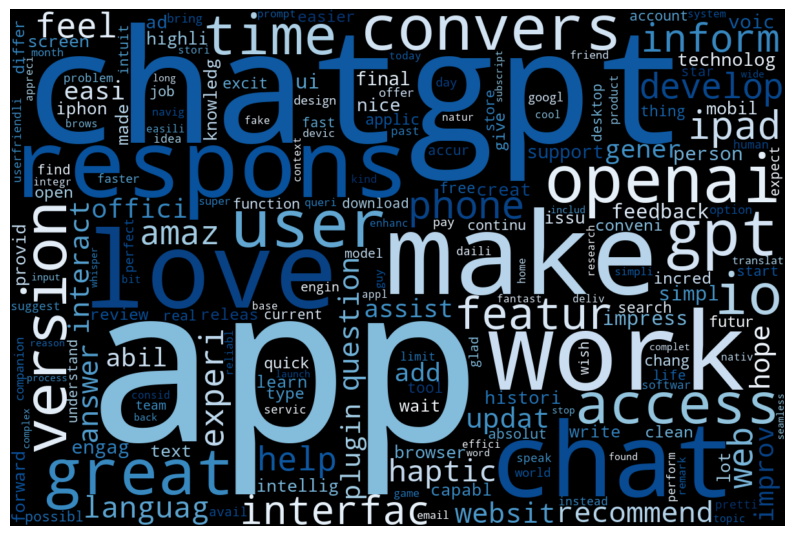

In [21]:
# untuk menampilkan wordcloud
def show_wordcloud(wc):
    plt.figure(figsize=(10, 8)) # penentu figure
    plt.axis("off") # menghilangkan penanda kooordinat
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

# menggabungkan semua kata yang ada di data menjadi satu
all_words = "".join([str(text).replace("'", "") for text in labeled_data.review[labeled_data.Labels == 5]])

# untuk menentukan wordcloud
word_cloud = WordCloud(
    width=1200, # lebar
    height=800, # tinggi 
    random_state=123, # keacakan seed
    colormap="Blues_r",
    collocations=False
).generate(all_words)

# menampilkan hasil wordcloud
show_wordcloud(word_cloud)

berikut merupakan komentar yang negatif sehingga kita bisa melakukan evaluasi

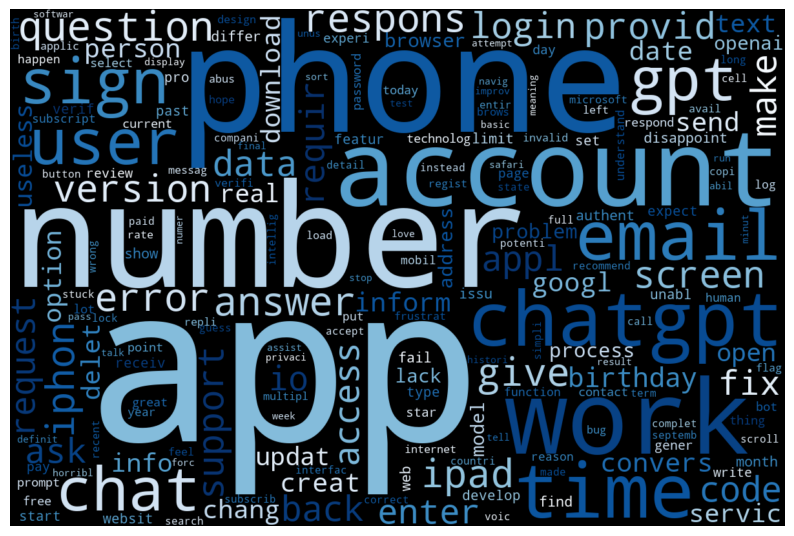

In [22]:
# untuk menampilkan wordcloud
def show_wordcloud(wc):
    plt.figure(figsize=(10, 8)) # penentu figure
    plt.axis("off") # menghilangkan penanda kooordinat
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

# menggabungkan semua kata yang ada di data menjadi satu
all_words = "".join([str(text).replace("'", "") for text in labeled_data.review[labeled_data.Labels == 1]])

# untuk menentukan wordcloud
word_cloud = WordCloud(
    width=1200, # lebar
    height=800, # tinggi 
    random_state=123, # keacakan seed
    colormap="Blues_r",
    collocations=False
).generate(all_words)

# menampilkan hasil wordcloud
show_wordcloud(word_cloud)

Kita dapat melihat pada kata yang sering muncul dalam komentar positif adalah komentar yang menjelaskan kelebihan chatgpt dan pujian. Sedangkan pada kata kata yang sering muncul pada komentar negatif adalah kata yang berisi feedback atau laporan bug.

### **Document Frequency**

Pada tahapan ini kita akan mencari dari semua term yang akan ditemukan nanti dan juga akan menghitung DF atau document frequency yaitu berapa banyak dokumen yang di dalamnya terdapat term tertentu. Tujuan dari mencari df adalah untuk mempersiapkan perhitungan idf

In [24]:
# untuk menyimpan semua term
word_set = []

# mencari semua term yang akan jadi feature
for doc in X_train:
    for word in doc:
        if word not in word_set:
            word_set.append(word)

# banyaknya dokumen
n_documents = len(X_train)

# akan memberikan index term
index_dict = {}
for i, term in enumerate(word_set):
    index_dict[term] = i

index_dict

{'app': 0,
 'phone': 1,
 'number': 2,
 '有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？': 3,
 'pay': 4,
 'access': 5,
 'brows': 6,
 'plugin': 7,
 'search': 8,
 'make': 9,
 'tool': 10,
 'useless': 11,
 'data': 12,
 'onlin': 13,
 'model': 14,
 '’': 15,
 'typic': 16,
 'write': 17,
 'review': 18,
 'offici': 19,
 'openai': 20,
 'shockingli': 21,
 'paragraph': 22,
 'chatgpt': 23,
 'gener': 24,
 'reviewchatgpt': 25,
 'complet': 26,
 'transform': 27,
 'engag': 28,
 'io': 29,
 'devic': 30,
 'valu': 31,
 'meaning': 32,
 'convers': 33,
 'exceed': 34,
 'expect': 35,
 'natur': 36,
 'languag': 37,
 'process': 38,
 'capabl': 39,
 'astound': 40,
 'interact': 41,
 'feel': 42,
 'humanlik': 43,
 'answer': 44,
 'complex': 45,
 'queri': 46,
 'offer': 47,
 'creativ': 48,
 'suggest': 49,
 'goto': 50,
 'companion': 51,
 'assist': 52,
 'task': 53,
 'simpli': 54,
 'friendli': 55,
 'chat': 56,
 'consist': 57,
 'deliv': 58,
 'immers': 59,
 'satisfi': 60,
 'experi': 61,
 'brilliant': 62,
 'friend': 63,
 'pocket': 64,


Lalu selanjutnya kita akan melakukan perhitungan untuk setiap term akan dihitung berapa banyak dokumen yang didalamnya ada term tersebut. Ini nanti akan membantu perhitungan IDF untuk perhitungan pembobotan kata

In [25]:
# akan mengembalikan dict term beserta hitungan df
def document_frequency(docs):
    # dictionary untuk menyimpan
    count_word = {} 

    # mencari untuk setiap term berapa banyak dokumen yang ada term itu
    for term in word_set:
        count_word[term] = 0
        for doc in docs:
            if term in doc:
                count_word[term] += 1
    
    return count_word

# mengimplementasikan pada dataset
count_word = document_frequency(X_train)
count_word


{'app': 384,
 'phone': 98,
 'number': 58,
 '有病吧，突破重重困难才下载了它，满怀欣喜得去登录，居然不给过，那又何必开放这破软件呢？': 1,
 'pay': 16,
 'access': 56,
 'brows': 11,
 'plugin': 24,
 'search': 19,
 'make': 83,
 'tool': 18,
 'useless': 13,
 'data': 19,
 'onlin': 4,
 'model': 21,
 '’': 297,
 'typic': 2,
 'write': 22,
 'review': 23,
 'offici': 28,
 'openai': 60,
 'shockingli': 1,
 'paragraph': 1,
 'chatgpt': 158,
 'gener': 31,
 'reviewchatgpt': 1,
 'complet': 13,
 'transform': 2,
 'engag': 19,
 'io': 52,
 'devic': 12,
 'valu': 3,
 'meaning': 8,
 'convers': 42,
 'exceed': 6,
 'expect': 22,
 'natur': 9,
 'languag': 26,
 'process': 19,
 'capabl': 20,
 'astound': 2,
 'interact': 26,
 'feel': 37,
 'humanlik': 4,
 'answer': 49,
 'complex': 9,
 'queri': 11,
 'offer': 13,
 'creativ': 9,
 'suggest': 12,
 'goto': 4,
 'companion': 12,
 'assist': 23,
 'task': 6,
 'simpli': 15,
 'friendli': 6,
 'chat': 73,
 'consist': 7,
 'deliv': 10,
 'immers': 5,
 'satisfi': 5,
 'experi': 36,
 'brilliant': 2,
 'friend': 10,
 'pocket': 4,
 'highli':

### **Term Frequency**

Pada tahapan ini kita akan memperhitungkan TF atau Term Frequency yaitu perhitungan berapa kali kata itu muncul dalam suatu dokumen dari banyaknya dokumen tersebut. Tujuannya adalah untuk mempersiapkan dalam perhitungan pembobotan kata. Salah satu nilai TF yang dapat dipahami adalah ketika nilainya mendekati nol maka kata tersebut sangat jarang muncul pada dokumen tersebut. Begitu juga dengan sebaliknya.

In [ ]:
def term_frequency(doc, term):
    n = len(doc)
    occurate = doc.count(term)

    return 



### **Inverse Document Frequency**

### **TF - IDF**

### **Feature Selection**

# **Modeling**

### **Create Class**

### **Training**

### **Testing**

### **Conclusion**